In [159]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [160]:
# #Install CCTX 
# !pip install ccxt

In [161]:
# #ccxt import 
# import ccxt
# print(ccxt.exchanges)

In [162]:
# %pip install yfinance mplfinance # used to download mplfinance

In [163]:
#sample tickers
tickers = ['AAPL', 'MSFT', 'GOOGL']
df = dict() #['tickers': df]
# historical_data  = ticker.history(period="7d", interval="1m")  # trying to get only 1m interval for 7period 

In [164]:
for ticker in tickers:
    df[ticker] = yf.download(ticker, start='2021-01-01', end='2021-12-31')
    # df[ticker] = ticker.history(period = "730d", interval = "1h") #periods scraping 730days and interval with only 1hrs 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [165]:
for ticker in tickers:
    df[ticker] = df[ticker].reset_index()

In [166]:
df['AAPL']

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,127.002090,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,128.572342,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,124.244370,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,128.483994,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,129.592987,105158200
...,...,...,...,...,...,...,...
246,2021-12-23,175.850006,176.850006,175.270004,176.279999,174.066513,68356600
247,2021-12-27,177.089996,180.419998,177.070007,180.330002,178.065659,74919600
248,2021-12-28,180.160004,181.330002,178.529999,179.289993,177.038696,79144300
249,2021-12-29,179.330002,180.630005,178.139999,179.380005,177.127594,62348900


# 1.Larry William Volatillity Breakout Strategy Formula
<img src="LarryWilliam.png" alt="LarryWilliamFormula" style="width:50%;" />


In [167]:
#The values you need for LarryWilliams 
#The Range can be calculated by subtracting the values of the daily high from the daily low; Range = High - Low
#Base Price, or Entry Price = Previous Day's Candle Close + (Range * K), with K being a constant of 0.6 to represent the noise ratio.    
def LarryWilliams(ticker, df, k): #df represents one of the ticker's data 
    k_str = str(k)
    df['Range'] = df['High'].shift(1) - df['Low'].shift(1)
    df = df.iloc[1:]
    df[f'{ticker} Lower range{k_str}'] = df['Open'] - (df['Range'] * k)
    df[f'{ticker} Higher range{k_str}'] = df['Open'] + (df['Range'] * k)
    # print( df['Lower range'])
    signals = [1 if row['Close'] >= row[f'{ticker} Higher range{k_str}'] else -1 if row['Close'] <= row[f'{ticker} Lower range{k_str}'] else 0 for index, row  in df.iterrows()]
    row , col = df.shape #length of rows and columns  
    df[f'{ticker} Signals{k_str}'] = [0 for _ in range(row)] #initialize the signal column with 0
    df[f'{ticker} Signals{k_str}'] =  signals[:]
    # print(signals)
    return df


In [ ]:
k_values = [0.25, 0.4, 0.5] #making several constants for comparison
for ticker in tickers: #iterating over the tickers 
    for k in k_values:
        df[ticker] = LarryWilliams(ticker, df[ticker], k)

# Signals
1: means to take long position <br>
-1: means to take short position<br>
0: means to hold 

# Calculate the return based on different values
- $1$ in dfs means to buy the stock
- $-1$ in dfs means to sell the stock
- $0$ in dfs means to hold<br>
When buying or selling, we are going to assume that close is the current price as yfinance does not offer the current price

In [169]:
#Intializing balance row for each tickers 
for ticker in tickers:
    for k in k_values: #iterating over the tickers
        k_str = str(k)
        df1 =df[ticker]
        row, col = df1.shape
        df1[f'{ticker} Balance{k_str}'] = [0 for _ in range(row)]
        df1[f'{ticker} Position{k_str}'] = [0 for _ in range(row)]
        df1[f'{ticker} Profit{k_str}'] = [0 for _ in range(row)]

In [ ]:
df['AAPL']

In [171]:
#making the positions for each tickers and also its return  
#as in we don't have the data for current price, we assume that just buying one stocks per day depending on positions 
# position = collections.defaultdict(int) # for position dictionary {ticker: 0}
# for ticker in tickers:
#     position[ticker] = 0
def calculate_return(df, k):
    k_str = str(k)
    for ticker in tickers: #traversing through each tickers 
        rows, cols = df[ticker].shape #checkin the shape for each df 
        # row['return'] = [0 for _ in range(rows)] #intialize the tickers columns for Return 
        balance = 0
        position = 0
        profit = 0
        for index, row in df[ticker].iterrows(): # row = df[ticker], iterate over each tick
            current_price = (row['High'] + row['Low']) / 2  #made up a current_price 
            # if index == 0:
            #     continue #skip the first row
            if row[f'{ticker} Signals{k_str}'] == 1: #signals = 1 indicates buy
                balance -= current_price  #Close here refers to 
                position += 1 
            elif row[f'{ticker} Signals{k_str}'] == -1: #signals = -1 indicates sell
                balance += current_price
                position -= 1 
            else: # hold 
                pass
            profit = balance + (position * current_price)
            df[ticker].at[index, f'{ticker} Profit{k_str}'] = profit
            df[ticker].at[index, f'{ticker} Balance{k_str}'] = balance
            df[ticker].at[index, f'{ticker} Position{k_str}'] = position
        

In [172]:
for k in k_values:
    calculate_return(df, k)

In [184]:
MSFT = df['MSFT']

In [ ]:
MSFT

# Plotting the grpah 
- For each K values 
- Profit vs Date graph 

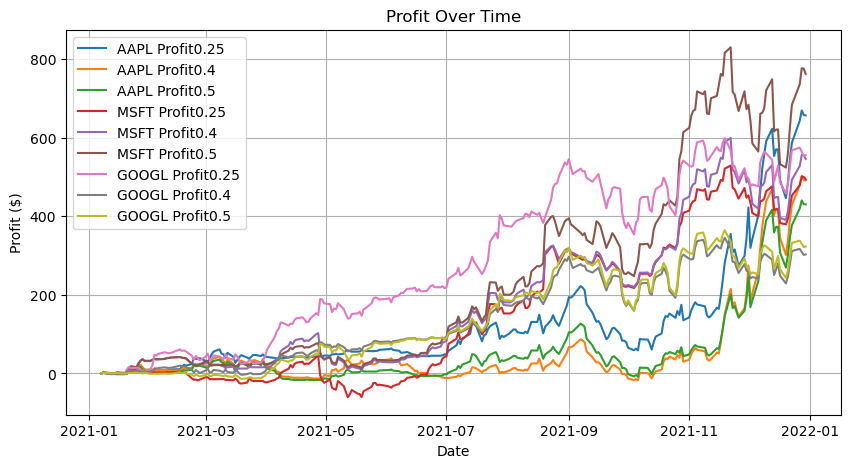

In [183]:
plt.figure(figsize=(10, 5))
for ticker in tickers:
    for k in k_values:
        k_str = str(k)
        plt.plot(df[ticker]['Date'], df[ticker][f'{ticker} Profit{k_str}'], label = f'{ticker} Profit{k_str}')
plt.title('Profit Over Time')  # Set the title of the graph
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Profit ($)')  # Set the y-axis label
plt.grid(True)  # Optional: Adds a grid for easier reading
plt.legend(loc='best')
plt.show()